In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cftime

sns.set_context('talk')

# Estimate the global sst trend

In [3]:
# read SST
sst = xr.open_dataset('../data/sst.mnmean.nc', decode_times=False).sst

In [4]:
y = (sst * np.cos(sst.lat * np.pi/180)).mean(('lat', 'lon'))
x = sst.time

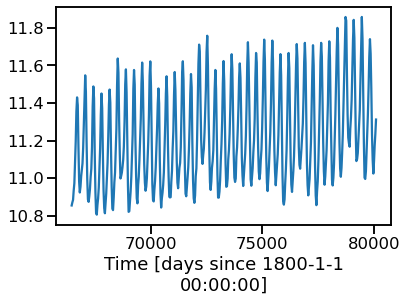

In [5]:
y = (sst * np.cos(sst.lat * np.pi / 180.)).mean(("lon", "lat"))
y.plot()

N = len(y)

In [6]:
cov = (
    1 / (N - 1)
    * (
        (y - y.mean('time'))
        * (x - x.mean('time'))
    ).sum()
)

corr = (
    cov
    / y.std('time', ddof=1)
    / x.std('time', ddof=1)
)

regression_slope = (
    corr 
    * y.std('time', ddof=1) 
    / x.std('time', ddof=1)
)

intercept = y.mean('time') - regression_slope * x.mean('time')

reg_line = lambda t: intercept + regression_slope * t

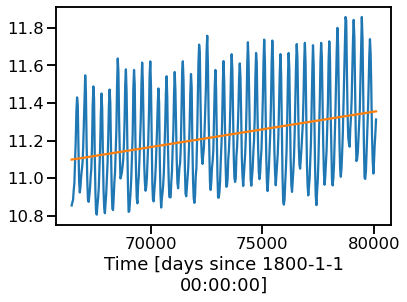

In [7]:
y.plot()
plt.plot(x, reg_line(x))

## Parametric estimation

In [8]:
# predicions using linear relationship
y_hat = reg_line(x)

# t-distribution with N-2 degrees of freedom
t_distr = sns.distributions.stats.t(df=N-2)

# standard error of the residuals
s_r = np.sqrt(N / (N - 2) * (1 - corr**2) * y.var())

# standard error of the regression slope
s_β = s_r / np.sqrt(N) / x.var()


s_f = s_r * np.sqrt(1 / N + (x - x.mean())**2 / (N - 1) / x.std()**2)
s_p = s_r * np.sqrt(1 + 1 / N + (x - x.mean())**2 / (N - 1) / x.std()**2)

# upper and lower bound of the CI for the estimator of the linear relationship
s_fl = y_hat + t_distr.ppf(0.025) * s_f
s_fu = y_hat + t_distr.ppf(0.975) * s_f

# upper and lower bound of the Ci for the predicion interval
s_pl = y_hat + t_distr.ppf(0.025) * s_p
s_pu = y_hat + t_distr.ppf(0.975) * s_p

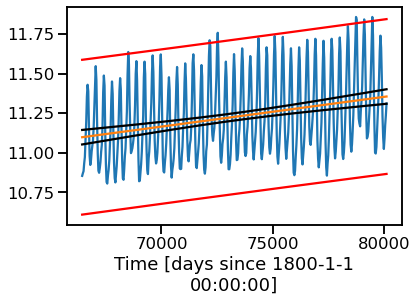

In [9]:
y.plot()
plt.plot(x, reg_line(x))
plt.plot(x, s_fl, 'k')
plt.plot(x, s_fu, 'k')
plt.plot(x, s_pl, 'r')
plt.plot(x, s_pu, 'r')

Text(0.5, 1.0, 'Residuals')

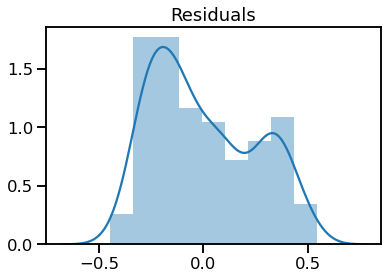

In [11]:
# distribution of the residuals
sns.distplot(y - y_hat)
plt.title("Residuals")

## Bootstrap approach

In [12]:
def linear_prediction(x, y):
    N = len(x)
    cov = (
    1 / (N - 1)
    * (
        (y - y.mean('time'))
        * (x - x.mean('time'))
    ).sum()
    )

    corr = (
        cov
        / y.std('time', ddof=1)
        / x.std('time', ddof=1)
    )

    regression_slope = (
        corr 
        * y.std('time', ddof=1) 
        / x.std('time', ddof=1)
    )

    intercept = y.mean('time') - regression_slope * x.mean('time')

#     reg_line = lambda t: intercept + regression_slope * t
    
    return [regression_slope, intercept]

### Resampling from joint distribution

In [14]:
%%time
n_replicate = 10000

index = list(range(N))

result = []

for i in range(n_replicate):
    ind_resample = np.random.choice(index, N)
    result.append(
        linear_prediction(
            x[ind_resample], 
            y[ind_resample]
        )
    )

result = np.array(result)

CPU times: user 43.5 s, sys: 43.5 ms, total: 43.5 s
Wall time: 43.5 s


In [15]:
y_hat_distr = result[:, 0] * x.values[:, np.newaxis] + result[:, 1]

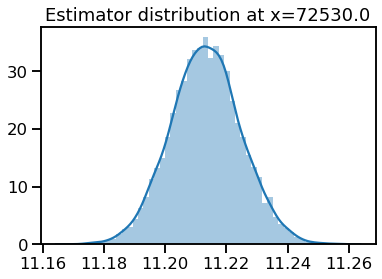

In [17]:
sns.distplot(y_hat_distr[200, :])
plt.title("Estimator distribution at x={}".format(x.values[200]));

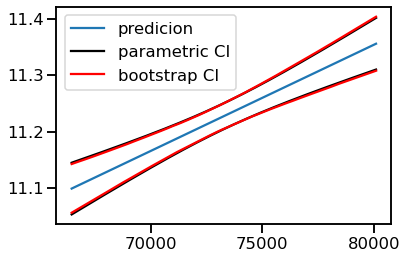

In [23]:
ci_forecast = np.percentile(y_hat_distr, (2.5, 97.5), axis=-1)

plt.plot(x, reg_line(x), label="predicion")
plt.plot(x, s_fl, 'k', label="parametric CI")
plt.plot(x, s_fu, 'k')
plt.plot(x, ci_forecast[0], 'r', label="bootstrap CI")
plt.plot(x, ci_forecast[1], 'r')
plt.legend();

### Resampling from residuals

In [24]:
%%time
n_replicate = 10000
residuals = y - y_hat

result = []

for i in range(n_replicate):
    resample_residual = np.random.choice(residuals, N)
    result.append(
        linear_prediction(
            x, 
            y_hat + resample_residual
        )
    )

CPU times: user 34.6 s, sys: 31.5 ms, total: 34.6 s
Wall time: 34.6 s


In [25]:
result = np.array(result)

In [26]:
y_hat_distr = result[:, 0] * x.values[:, np.newaxis] + result[:, 1]
ci_forecast_2 = np.percentile(y_hat_distr, (2.5, 97.5), axis=-1)

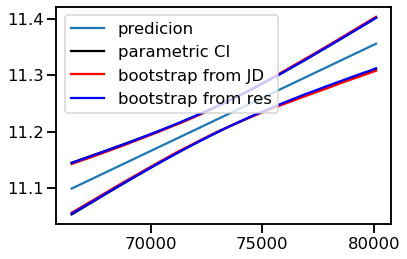

In [28]:
plt.plot(x, reg_line(x), label="predicion")
plt.plot(x, s_fl, 'k', label="parametric CI")
plt.plot(x, s_fu, 'k')
plt.plot(x, ci_forecast[0], 'r', label="bootstrap from JD")
plt.plot(x, ci_forecast[1], 'r')
plt.plot(x, ci_forecast_2[0], 'b', label="bootstrap from res")
plt.plot(x, ci_forecast_2[1], 'b')
plt.legend();